## Inference with models trained on Baranquilla 40cm imagery and assessed on Baranquilla Resampled 40cm test imagery

This notebook demonstrates how you can launch training script, compare model performance and load the weights of a trained model, then use this for inference and store the segmentation maps.

In [1]:
"""
Trains a Segmentalist model on a dataset and saves the resulting model checkpoints.


"""
import re
import operator
import logging
import pickle
import time
import argparse

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import tensorflow as tf
import tensorflow_addons as tfa
import kerastuner as kt
import sys
import pprint
import yaml
import uuid
import albumentations as A
import joblib 

import gim_cv.config as cfg
import gim_cv.utils as utils
import gim_cv.losses as losses
import gim_cv.datasets as datasets
import gim_cv.tools.keras_one_cycle_clr as clr

from functools import partial, reduce
from pathlib import Path
from time import perf_counter as pc

#from sklearn.externals import joblib
from tensorflow.keras.models import load_model
from distributed import Client, LocalCluster
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow_addons.optimizers import SWA
#from zarr.errors import ArrayNotFoundError

from gim_cv.models.segmentalist import Segmentalist
from gim_cv.training import TrainingDataset, pair_batch_generator, CompositeTrainingDataset, fancy_batch_generator
from gim_cv.datasets import (get_dataset,
                             get_image_training_pipeline_by_tag,
                             get_binary_mask_training_pipeline_by_tag,
                             list_datasets)
from gim_cv.preprocessing import get_aug_datagen, FancyPCA, strong_aug, balanced_oversample
from gim_cv.utils import plot_pair, parse_kwarg_str
from gim_cv.tuners import HyperbandOCP
###
import os
import time

# the model saving/loading utility functions live in the utils.py module in bin with the scripts
sys.path.append('../../bin')
from bin import utils
from PIL import Image

from contextlib import contextmanager

from numpy.lib.stride_tricks import as_strided

import math
import imageio
import numbers
import rioxarray as rx

- timbermafia has configured handlers:
  - <StreamHandler stdout (NOTSET)>
- name gim-cv given, generated named logger.


In [2]:
datasets.get_dataset('train_tif').mask_paths

[PosixPath('/home/root/TRAIN/masks/Medellin_ground_truth.tif')]

In [4]:
log = logging.getLogger()
if True:
    # 
    assert tf.test.is_gpu_available(), "CHECK GPU AVAILABILITY! (eg /etc/docker/daemon.json default runtime)"
    #
    np.random.seed(cfg.seed)
    # set window/patch size
    patch_dims = (256, 256)
    # process necessary parser arguments
    layer_blocks_ = [int(n) for n in '2,2,2,2'.split(',')]
    residual_filters_ = [int(n) for n in '128,256,512,1024'.split(',')]
    initial_kernel_size_ = (7, 7)
    head_kernel_size_ = (1, 1)
    # decide partitioning into train/validation
    train_val_test_split = (1.-0.1, 0.1)
    # --- assemble training datasets
    # get dataset tags - sort to fix order to identify different permutations for array caching
    dataset_tags = sorted(['train_tif'])
    # get each of the training datasets requested
    tdsets = []
    for ds_tag in ['train_tif']:
        ds = datasets.get_dataset(ds_tag)
        rf = ds.spatial_resolution/0.4
        tdsets.append(ds.load_training_data(batch_size=4, train_val_test_split=train_val_test_split, seed=cfg.seed, window_size=256, overlap_tiles=True, resample_factor=rf))
    # combine them into one big (composite) training dataset
    if len(tdsets) == 1:
        tds = tdsets[0]
    else:
        tds = reduce(operator.add, tdsets)
    # create a string to identify the combination of datasets and the spatial resolution
    # used in saving model checkpoints to quickly identify training data used
    data_res_str = f"data_{tds.tags_str}_target_res_{0.4}"
    data_res_str += '_overlapping_tiles'
    # set the cache directory to save preprocessed arrays in an appropriately named directory
    tds.cache_directory = cfg.proc_data_path / Path(data_res_str)
    # --- preprocess training data
    # generate arrays from rasters on-the-fly at training time
    tds.prepare()
    # skipped              
    # --- assign data generator for scaling, augmentations etc
    # albumentations + fancyPCA => "fancy" augs. recommended.
    if True:
        log.warning("~~ Fancy augs on ~~")
        # start distributed cluster for mapping augmentations
        client = Client(processes=False)
        log.info("Calculating PCA decomposition of training RGBs...")
        fpca = FancyPCA(tds.X_train, alpha_std=.3, p=1.0)
        log.warning(f"Eigenvalues are {fpca.sampler.eig_vals}")
        log.warning(f"Eigenvectors are {fpca.sampler.eig_vecs}")
        augger = strong_aug(p=.8, fancy_pca=fpca)
        tds.batch_generator_fn = partial(fancy_batch_generator, batch_size=4, augger=augger, client=client, seed=cfg.seed, shuffle_blocks_every_epoch=True, shuffle_within_blocks=True, deep_supervision=True, float32=True)
        aug_sfx = 'fancy'
    ## --- configure model training
    # get loss function and any kwargs (entered as a string to argparser)
    loss_fn_name, *lf_kwarg_str = 'dice_coeff_loss'.split(':')
    # grab func itself from losses module by name
    loss_fn = getattr(losses, loss_fn_name)
    # optionally provide kwargs to higher-order function to return lf
    if lf_kwarg_str:
        lf_kwargs = parse_kwarg_str(*lf_kwarg_str)
        loss_fn = loss_fn(**lf_kwargs)
    else:
        lf_kwargs = {}
    # encode loss function args as a cleaned-up string for identifying models trained with this
    lfastr = '_args_' + '_'.join([f'{k}={v:.2f}' for k, v in lf_kwargs.items()]) if lf_kwargs else ''
    # calculate number of training and validation steps
    train_steps = tds.X_train.shape[0]//4
    valid_steps = tds.X_val.shape[0]//4
    print(f'train_steps={train_steps}')
    print(f'val_steps={valid_steps}')
    if True:
        assert tds.X_val.shape[0] > 0, (
            "Not enough dask blocks to make up validation data frac!\n"
            f"train: {tds.X_train}"
        )
    # select metrics
    metrics = [losses.tversky_index, losses.jaccard_index, losses.recall, losses.precision, losses.specificity, losses.npv, losses.dice_coefficient]
    # interpret optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) # check out RADAM?
    # stoachastic weight averaging if enabled
    opt = SWA(opt, start_averaging=100 - 50, average_period=5)
    # specify training directory to save weights and metrics for this loss_fn and data ID
    project_name = Path(f'Segmentalist_{uuid.uuid4()}')
    training_dir = Path(str(cfg.models_path)) / project_name
    training_dir.mkdir(parents=True, exist_ok=True)
    # -- callbacks
    # early stopping
    monitor = 'loss'
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor, patience=7)]
    # reduce the learning rate on plateaus
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor,factor=0.5,patience=2, min_lr=0.000001))
    # set up tensorboard to record metrics in a subdirectory
    tb_pth = training_dir / Path("metrics/")
    tb_cb = tf.keras.callbacks.TensorBoard(log_dir=str(tb_pth),update_freq=50)
    callbacks.append(tb_cb)
    # set up checkpoints in the training directory
    cp_fmt = 'cp-e{epoch:02d}-ji{jaccard_index:.5f}-l{loss:.5f}'
    suffix = '-vl{val_loss:.5f}.ckpt'
    cp_fmt = cp_fmt + '-vl0.00.ckpt' # suffix
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor=monitor, save_best_only=True, save_weights_only=True, verbose=1)
    cp_callback_trn = tf.keras.callbacks.ModelCheckpoint(filepath=str(training_dir / Path(cp_fmt)), monitor='loss', save_best_only=True, save_weights_only=True, verbose=1)
    # callbacks.append(cp_callback)
    callbacks.append(cp_callback_trn)
    # --- build and compile the model
    # format attention gate param
    ag = 'SAG'
    model = Segmentalist(n_classes=tds.y_train.shape[-1], layer_blocks=[2,2,2,2], last_decoder_layer_blocks=2, initial_filters=64, residual_filters=[128,256,512,1024],
        initial_kernel_size=(7, 7), head_kernel_size=(1, 1), cardinality=1, act='relu', downsample='pool',
        decoder_attention_gates=ag, encoder_cbam=True, decoder_cbam=True, pyramid_pooling=True, deep_supervision=True, lambda_conv=True,)
    model.build(input_shape=(4, 256, 256, tds.X_train.shape[-1]))
    model.compile(optimizer=opt, loss=loss_fn, metrics=metrics)
    # option to dump test data removed for testing session
    # dump setup
    # augmentations
    A.save(augger, f'{training_dir}/transform.yml', data_format='yaml')
    # 
    log.info("Start training...")
    # 
    args = {'datasets': 'train_tif', 'target_spatial_resolution': 0.4, 'pyramid_pooling': True, 'deep_supervision': True, 'lambda_conv': True, 'encoder_cbam': True, 'decoder_cbam': True, 'sag': True, 'csag': True, 'layer_blocks': '2,2,2,2', 'layer_blocks_' : [2,2,2,2], 'last_decoder_layer_blocks': 2, 'initial_filters': 64, 'residual_filters': '128,256,512,1024', 'residual_filters_' : [128,256,512,1024], 'initial_kernel_size': 7, 'initial_kernel_size_' : (7, 7), 'head_kernel_size': 1, 'head_kernel_size_' : (1, 1), 'cardinality': 1, 'activation': 'relu', 'downsample': 'pool', 'patch_size': 256, 'overlapping_tiles': True, 'epochs': 100, 'batch_size': 4, 'loss_fn': 'dice_coeff_loss', 'optimiser': 'adam', 'swa': True, 'duration_swa': 50, 'period_swa': 5, 'use_val': False, 'patience': 7, 'seed': 42, 'val_frac': 0.1, 'test_frac': 0.0, 'fancy_augs': True, 'lr_init': 0.0001, 'lr_min': 1e-06, 'lr_reduce_factor': 0.5, 'lr_reduce_patience': 2, 'ocp': False, 'balanced_oversample': False, 'models_dir': str(cfg.models_path), 'dump_test_data': False, 'dump_first_batches': False, 'use_cache': False, 'save_to_cache': False}
    # 
    with open(f'{training_dir}/run_params.yml', 'w') as outfile:
        yaml.dump(args, outfile, default_flow_style=False)
    # --- train the model
    print('fit model')
    model.fit(tds.batch_gen_train(), steps_per_epoch=train_steps, epochs=100, max_queue_size=50, callbacks=callbacks, 
              validation_data=tds.batch_gen_val(), validation_steps=valid_steps)
    # validation_data=tds.batch_gen_val(), validation_steps=valid_steps,


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
06:17:34  I  …iteTrainingDataset.prune  Selecting training datasets to eliminate with               
                                        has_empty_raster...                                         
06:17:34  D  …iningDataset.load_arrays  loading arrays                                              
06:17:34  D  …iningDataset.load_arrays  done loading arrays                                         
06:17:34  I  …iteTrainingDataset.prune  Removed 0 TrainingDatasets, leaving 1.                      
06:17:34  D    TrainingDataset.prepare  Obtaining arrays for                                        
                                        /home/root/TRAIN/rasters/Medellin_40cm.tif,                 
                                        /home/root/TRAIN/masks/Medellin_ground_truth.tif...         
06:17:34  D  …iningDataset.load_arrays  loading arrays                                              
06:17:34  

06:17:34  D      TileStacker.transform  Reshaping array into tiles...                               
06:17:34  D      TileStacker.transform  Reshaping array into tiles...                               
06:17:34  D  …erlappingTiler.transform  Assembling overlapping tiles...                             
06:17:34  I    TrainingDataset.prepare  Image pipeline done!                                        
06:17:34  D   DimensionAdder.transform  Leaving array shape alone...                                
06:17:34  D       OverlappingTiler.fit  Dividing array with shape (2519, 3579, 1) into half-step    
                                        overlapping tiles...                                        
06:17:34  D                  Tiler.fit  Shape going into stacker: (2519, 3579, 1)                   
06:17:34  D     WindowFitter.transform  Transforming input data to match integer number of          
                                        windows...                                         

06:17:35  I  …eTrainingDataset.prepare  Aligning image/mask array chunks...                         
06:17:35  I  …eTrainingDataset.prepare  Shuffling datasets together...                              
06:17:35  I  …eTrainingDataset.prepare  Composite dataset prepare done!                             


~~ Fancy augs on ~~
Eigenvalues are [0.09350873 0.00181782 0.00032194]
Eigenvectors are [[-0.60542937 -0.78462329  0.13349747]
 [-0.56988798  0.310276   -0.76089191]
 [-0.55559245  0.53674492  0.63499758]]


train_steps=126
val_steps=14
fit model
Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


126/126 [==============================] - ETA: 0s - loss: 0.3502 - tversky_index: 0.6929 - jaccard_index: 0.5135 - recall: 0.8263 - precision: 0.5919 - specificity: 0.5849 - npv: 0.7809 - dice_coefficient: 0.6498
Epoch 00001: loss improved from inf to 0.35021, saving model to /home/root/saved_models/Segmentalist_d748495e-d44e-4750-bc76-c7400cb70d14/cp-e01-ji0.51349-l0.35021-vl0.00.ckpt
126/126 [==============================] - 296s 2s/step - loss: 0.3502 - tversky_index: 0.6929 - jaccard_index: 0.5135 - recall: 0.8263 - precision: 0.5919 - specificity: 0.5849 - npv: 0.7809 - dice_coefficient: 0.6498 - val_loss: 0.9998 - val_tversky_index: 1.3306e-04 - val_jaccard_index: 9.1916e-05 - val_recall: 1.1016e-04 - val_precision: 0.4522 - val_specificity: 0.9788 - val_npv: 0.6503 - val_dice_coefficient: 1.8382e-04 - lr: 1.0000e-04
Epoch 2/100
126/126 [==============================] - ETA: 0s - loss: 0.3379 - tversky_index: 0.7125 - jaccard_index: 0.5327 - recall: 0.8966 - precision: 0.5860 

Epoch 15/100
126/126 [==============================] - ETA: 0s - loss: 0.2488 - tversky_index: 0.7825 - jaccard_index: 0.6439 - recall: 0.8776 - precision: 0.7096 - specificity: 0.7699 - npv: 0.8732 - dice_coefficient: 0.7512
Epoch 00015: loss did not improve from 0.22542
126/126 [==============================] - 286s 2s/step - loss: 0.2488 - tversky_index: 0.7825 - jaccard_index: 0.6439 - recall: 0.8776 - precision: 0.7096 - specificity: 0.7699 - npv: 0.8732 - dice_coefficient: 0.7512 - val_loss: 0.4233 - val_tversky_index: 0.5463 - val_jaccard_index: 0.4574 - val_recall: 0.5879 - val_precision: 0.7853 - val_specificity: 0.9014 - val_npv: 0.8092 - val_dice_coefficient: 0.5767 - lr: 2.5000e-05
Epoch 16/100
126/126 [==============================] - ETA: 0s - loss: 0.2094 - tversky_index: 0.8170 - jaccard_index: 0.6938 - recall: 0.9036 - precision: 0.7552 - specificity: 0.7922 - npv: 0.8903 - dice_coefficient: 0.7906
Epoch 00016: loss improved from 0.22542 to 0.20939, saving model to 

Epoch 26/100
126/126 [==============================] - ETA: 0s - loss: 0.1972 - tversky_index: 0.8183 - jaccard_index: 0.7158 - recall: 0.8860 - precision: 0.7856 - specificity: 0.8356 - npv: 0.8842 - dice_coefficient: 0.8028
Epoch 00026: loss did not improve from 0.17652
126/126 [==============================] - 285s 2s/step - loss: 0.1972 - tversky_index: 0.8183 - jaccard_index: 0.7158 - recall: 0.8860 - precision: 0.7856 - specificity: 0.8356 - npv: 0.8842 - dice_coefficient: 0.8028 - val_loss: 0.3846 - val_tversky_index: 0.6164 - val_jaccard_index: 0.4768 - val_recall: 0.6473 - val_precision: 0.6673 - val_specificity: 0.7889 - val_npv: 0.8052 - val_dice_coefficient: 0.6154 - lr: 1.2500e-05
Epoch 27/100
126/126 [==============================] - ETA: 0s - loss: 0.2125 - tversky_index: 0.8044 - jaccard_index: 0.6943 - recall: 0.8827 - precision: 0.7746 - specificity: 0.8357 - npv: 0.8858 - dice_coefficient: 0.7875
Epoch 00027: loss did not improve from 0.17652
126/126 [============

Epoch 38/100
126/126 [==============================] - ETA: 0s - loss: 0.1670 - tversky_index: 0.8562 - jaccard_index: 0.7457 - recall: 0.9228 - precision: 0.7987 - specificity: 0.8349 - npv: 0.9230 - dice_coefficient: 0.8330
Epoch 00038: loss did not improve from 0.16169
126/126 [==============================] - 285s 2s/step - loss: 0.1670 - tversky_index: 0.8562 - jaccard_index: 0.7457 - recall: 0.9228 - precision: 0.7987 - specificity: 0.8349 - npv: 0.9230 - dice_coefficient: 0.8330 - val_loss: 0.3427 - val_tversky_index: 0.6608 - val_jaccard_index: 0.5627 - val_recall: 0.7510 - val_precision: 0.7236 - val_specificity: 0.9037 - val_npv: 0.9023 - val_dice_coefficient: 0.6573 - lr: 1.0000e-06


In [3]:
df_segm_trained = utils.collate_run_data(Path(str(cfg.models_path)), model_name='Segmentalist')
# 
df_segm_trained = df_segm_trained.drop(['seed', 'save_to_cache'] + [c for c in df_segm_trained.columns if any(i in c for i in ('_train',  'ocp', 'fancy_augs', 'dump_test_data', 'dump_first_batches', 'channel_expansion_factor'))], axis=1).sort_values(by='lowest_loss')
# we can select a sub
view_cols = ['datasets', 'lowest_loss', 'balanced_oversample', 'batch_size', 'patch_size', 'overlapping_tiles', 'deep_supervision', 'target_spatial_resolution', 'pyramid_pooling', 'loss_fn', 'val_frac']
# 
df_segm_trained[view_cols + ['uuid4'] ] # 
row = df_segm_trained.query('datasets == "train_tif"').iloc[0]
# row
inference_window_size = 1024
# load again with new patch shape
model = Segmentalist.load_from_metadata(row=row)
# shouldn't have to run these lines, LRM will look at the method above and fix so weight loading is included properly...
# workaround which fixes weight loading; "prime" model on something of the right shape
model(np.random.rand(1, inference_window_size, inference_window_size, 3))
model.load_weights(row.lowest_loss_ckpt) # takes a wee minute
model.stop_training = True


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [4]:
def extract_patches(arr, patch_shape=(640,640,3), extraction_step=512):
    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches
#

-----------------------------------------------------------
Running prediction on image:   Medellin_40cm.tif


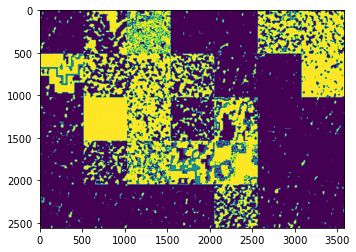

In [6]:
path_to_dir = str(cfg.infer_data_tif_path) # '/home/root/tests/resources/infer_data_tif' # infer_data_tif
tif_files = [tif for tif in os.listdir(path_to_dir) if '.tif' in tif]
for image_name in tif_files:
    print('-----------------------------------------------------------')
    print("Running prediction on image:  ", image_name)
    # specify the repository where the input file is located and its name
    # path_to_dir = '/home/root/data/volumes/datasets/baranquilla_full_40cm/' # baranquilla_merged_33_resampled_40cm
    path_to_file_complete = os.path.join(path_to_dir, image_name)
    # print("----------------------------------------------------------------------------------------------------")
    # print(path_to_file_complete)
    img = imageio.imread(path_to_file_complete)
    # plt.imshow(img)
    # patches = extract_patches(img)
    # print(patches.shape)
    # print(patches.reshape((-1, 1024, 1024, 3)).shape)
    image_size = img.shape
    # print("image size :", image_size)
    input_patch_size = (512, 512, 3)
    padded_image_size = [math.ceil(image_size[i]/input_patch_size[i]) * (input_patch_size[i]) for i in range(3)]
    # print("padded image size :", padded_image_size)
    topad = []
    for i in range(len(image_size)-1):
        if (padded_image_size[i] - image_size[i])%2 == 0:
            topad.append((int((padded_image_size[i]- image_size[i])/2), int((padded_image_size[i]- image_size[i])/2)))
        else:
            topad.append((int((padded_image_size[i]- image_size[i])//2), int((padded_image_size[i]- image_size[i])//2)+1))
    topad.append((0,0))
    # print(tuple(topad))
    ###
    ret = np.pad(img, pad_width=tuple(topad), mode='reflect')
    # print("Confirm new padded image size :", ret.shape)
    ###
    # proceed to extract overlapping patches
    ret_patches = extract_patches(ret, patch_shape=(512,512,3), extraction_step=512)
    # print(ret_patches.shape)
    # X = np.transpose(patches.reshape((-1, 32, 32, 3)), (0, 3, 1, 2))
    # print(ret_patches.reshape((-1, 512, 512, 3)).shape)
    # plt.imshow(ret)
    # Extra padding step to account for patch overlap during prediction process
    aug_img = np.pad(ret, pad_width=((256, 256), (256, 256), (0, 0)), mode='reflect')
    # print("Check newly padded (augmented) image size :", aug_img.shape)
    # plot augmented image
    # plt.imshow(aug_img)
    # proceed to extract overlapping patches
    aug_patches = extract_patches(aug_img, patch_shape=(1024,1024,3), extraction_step=512)
    topredict = aug_patches.reshape((-1, 1024, 1024, 3))
    pred_aug_patches = []
    for i in range(aug_patches.reshape((-1, 1024, 1024, 3)).shape[0]):
        pred_aug_patches.append(model(topredict[i,:,:,:][None, ...]/255.))
    pred_aug_patchex = np.array(np.squeeze(pred_aug_patches))
    (I,J,K) =  (ret.shape[0]//512, ret.shape[1]//512, 3)
    reconst_img = np.empty((ret.shape[0],ret.shape[1]), float)
    index = 0
    for i in range(I):
        # print('j : ', j)
        for j in range(J):
            # print('i : ', i)
            reconst_img[512*i:512*(i+1), 512*j:512*(j+1)] = pred_aug_patchex[index,256:1024-256,256:1024-256] # aug_patches.reshape((-1, 640, 640, 3))[index,64:640-64,64:640-64,:]
            index += 1
        #
    #
    # print()
    # print(reconst_img.shape)
    plt.imshow(reconst_img)
    reconst_img_origin = reconst_img[topad[0][0]:reconst_img.shape[0]-topad[0][1],topad[1][0]:reconst_img.shape[1]-topad[1][1]]
    ###
    # np.save('predImg_output_xyz.npy', reconst_img_origin)
    ###
    datenow = time.strftime("%Y%m%d-%H%M%S")
    output_name = "Model_Segmentalist_infer_" + image_name + "_" + datenow + ".tif" # 'predictedImgOutput.tif'
    output_path = cfg.predictions_data_tif_path / Path(output_name)
    with rasterio.open(path_to_file_complete) as src:
        profile = src.profile
        profile.update(count=1)
        with rasterio.open(output_path, 'w', **profile) as dst:
            #
            dst.write(tf.cast(reconst_img_origin*255., tf.uint8), indexes=1)